In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5048/868335/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1678730552&Signature=SDcp80nGSx0qkBXWGLTHMvU7duZYTkdKJTPTYctP4wemz%2BlHoD7UesW2Uku9mThrkweHeruI7bOUyTlbrHJ%2B0Dw0Wt7Qfe1celmIqQLfAQd4XK16DsoVkmSjsf%2B%2B8g2RiDM%2F8tZeB8EDI3yftZ%2B9ETqfBC9ZR%2F4k7SR13alf5dYxGiejy58UWYTM7k9wk9QIacHUksYiMfM4Jlm%2Bq4zI0TvgnJZ8YNl%2FWOub3g4sOxC24sbNURhay2K%2BYUOrlFTUu79h63VaZO2oDofdoMd5VJDfR6NZPADSDcyUbVzWBjZyvYHgX9oDXX6IxvjcUF4ngNV5idi5%2FP5yyNq7YVJZlQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dstate-farm-distracted-driver-detection.zip" -c -O 'state-farm-distracted-driver-detection.zip'

--2023-03-11 09:58:22--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5048/868335/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1678730552&Signature=SDcp80nGSx0qkBXWGLTHMvU7duZYTkdKJTPTYctP4wemz%2BlHoD7UesW2Uku9mThrkweHeruI7bOUyTlbrHJ%2B0Dw0Wt7Qfe1celmIqQLfAQd4XK16DsoVkmSjsf%2B%2B8g2RiDM%2F8tZeB8EDI3yftZ%2B9ETqfBC9ZR%2F4k7SR13alf5dYxGiejy58UWYTM7k9wk9QIacHUksYiMfM4Jlm%2Bq4zI0TvgnJZ8YNl%2FWOub3g4sOxC24sbNURhay2K%2BYUOrlFTUu79h63VaZO2oDofdoMd5VJDfR6NZPADSDcyUbVzWBjZyvYHgX9oDXX6IxvjcUF4ngNV5idi5%2FP5yyNq7YVJZlQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dstate-farm-distracted-driver-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4296022692 (4.0G) [application/zip]
Saving to: ‘state-fa

In [ ]:
!unzip 'state-farm-distracted-driver-detection.zip'

Archive:  state-farm-distracted-driver-detection.zip
  inflating: driver_imgs_list.csv    
  inflating: imgs/test/img_1.jpg     
  inflating: imgs/test/img_10.jpg    
  inflating: imgs/test/img_100.jpg   
  inflating: imgs/test/img_1000.jpg  
  inflating: imgs/test/img_100000.jpg  
  inflating: imgs/test/img_100001.jpg  
  inflating: imgs/test/img_100002.jpg  
  inflating: imgs/test/img_100003.jpg  
  inflating: imgs/test/img_100004.jpg  
  inflating: imgs/test/img_100005.jpg  
  inflating: imgs/test/img_100007.jpg  
  inflating: imgs/test/img_100008.jpg  
  inflating: imgs/test/img_100009.jpg  
  inflating: imgs/test/img_10001.jpg  
  inflating: imgs/test/img_100010.jpg  
  inflating: imgs/test/img_100011.jpg  
  inflating: imgs/test/img_100012.jpg  
  inflating: imgs/test/img_100013.jpg  
  inflating: imgs/test/img_100014.jpg  
  inflating: imgs/test/img_100016.jpg  
  inflating: imgs/test/img_100017.jpg  
  inflating: imgs/test/img_100018.jpg  
  inflating: imgs/test/img_100019.jpg 

In [5]:
labels = pd.read_csv('driver_imgs_list.csv')
sample = pd.read_csv('sample_submission.csv')
 
# folders paths
train_path = "/kaggle/working/imgs/train"
test_path = "/kaggle/working/imgs"

In [6]:
labels.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
val_ratio = 0.2
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = val_ratio
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

In [8]:
train_data = train_gen.flow_from_directory(
    train_path,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = "training"
)

val_data = train_gen.flow_from_directory(
    train_path,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = "validation"
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


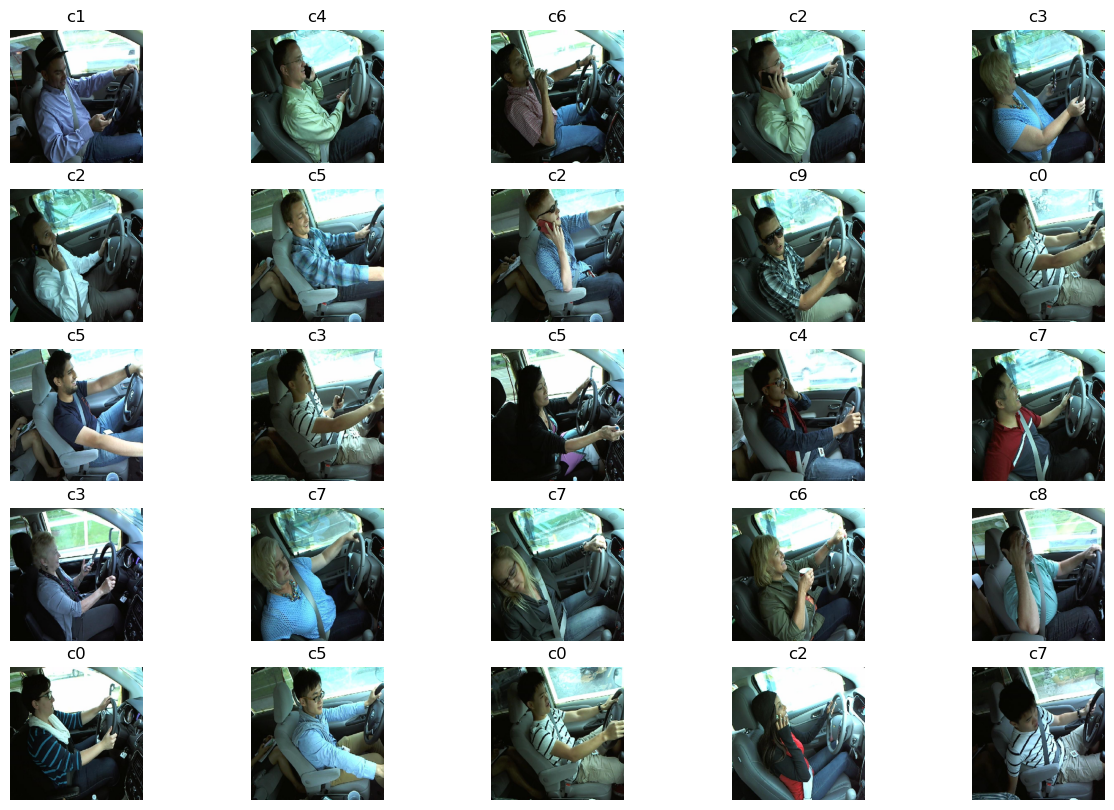

In [9]:
x,y = next(train_data)
a = train_data.class_indices
class_names = list(a.keys())  # storing class names in a list
 
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i].astype('uint8'))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

#### **Class Labels**

c0: safe driving

c1: texting - right

c2: talking on the phone - right

c3: texting - left

c4: talking on the phone - left

c5: operating the radio

c6: drinking

c7: reaching behind

c8: hair and makeup

c9: talking to passenger

In [10]:
def build_model(num_class):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=inputs)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=num_class, activation=tf.keras.activations.softmax)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-6),
    loss= tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy','Recall'],
    )
    return model

In [11]:
model = build_model(10)
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [12]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [13]:
batch_size=32
STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
STEP_SIZE_VALID = val_data.n//val_data.batch_size
 
# fit model
history = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=[early]
)

Epoch 1/10
560/560 [==============================] - 608s 1s/step - loss: 2.6014 - accuracy: 0.1919 - recall: 0.0650 - val_loss: 1.8462 - val_accuracy: 0.3683 - val_recall: 0.0993
Epoch 2/10
560/560 [==============================] - 563s 1s/step - loss: 1.6650 - accuracy: 0.4393 - recall: 0.2280 - val_loss: 1.1593 - val_accuracy: 0.6625 - val_recall: 0.3864
Epoch 3/10
560/560 [==============================] - 563s 1s/step - loss: 1.1107 - accuracy: 0.6537 - recall: 0.4470 - val_loss: 0.7634 - val_accuracy: 0.8047 - val_recall: 0.6225
Epoch 4/10
560/560 [==============================] - 561s 1s/step - loss: 0.7665 - accuracy: 0.7801 - recall: 0.6262 - val_loss: 0.5291 - val_accuracy: 0.8763 - val_recall: 0.7614
Epoch 5/10
560/560 [==============================] - 562s 1s/step - loss: 0.5449 - accuracy: 0.8584 - recall: 0.7490 - val_loss: 0.3786 - val_accuracy: 0.9203 - val_recall: 0.8446
Epoch 6/10
560/560 [==============================] - 563s 1s/step - loss: 0.4077 - accuracy: 0

In [14]:
model.save('Xception.h5')

Text(0.5, 0, 'epoch')

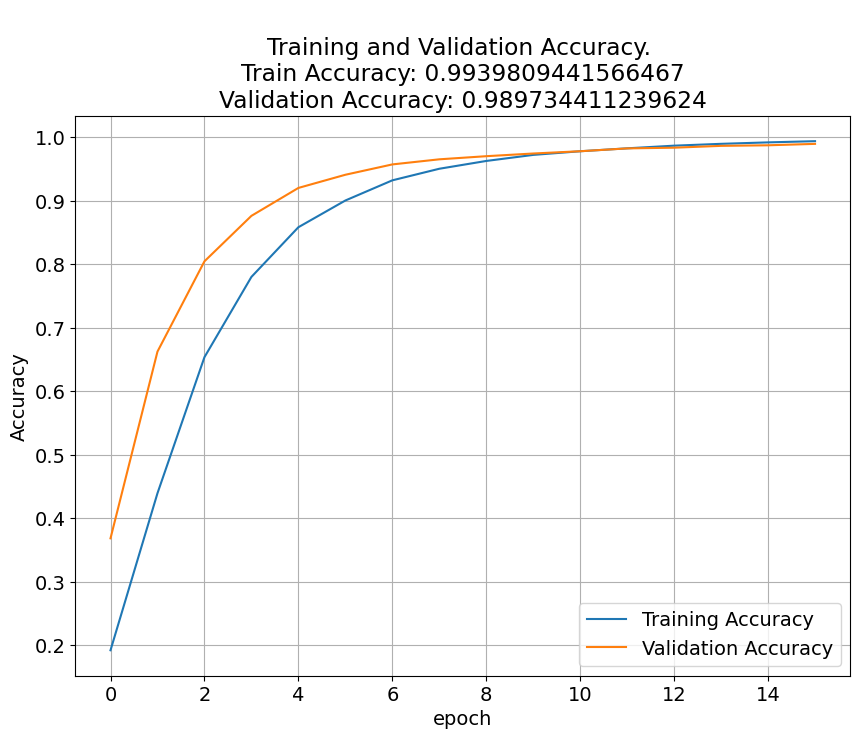

In [31]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.xlabel('epoch')


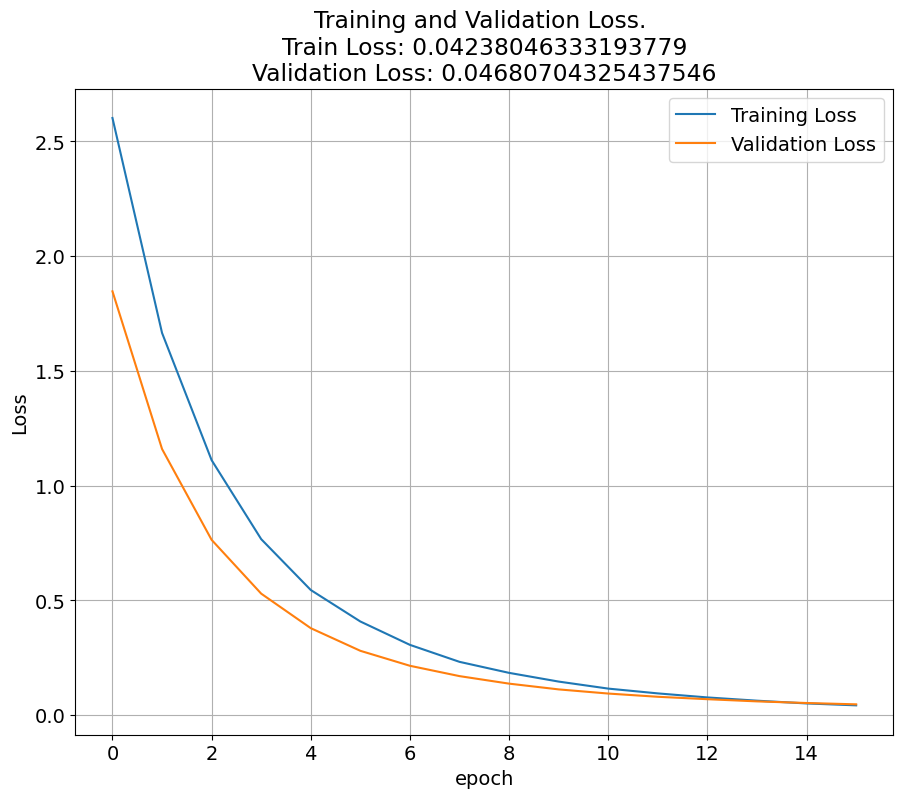

In [30]:
# loss
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [18]:
# unfreezing the penultimate layer of the model
set_trainable = False
for layer in model.layers:
    if layer.name == 'dropout (Dropout)':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)

In [20]:
fine_tune_epochs = 5
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
561/561 [==============================] - 562s 1s/step - loss: 0.1153 - accuracy: 0.9781 - recall: 0.9647 - val_loss: 0.0938 - val_accuracy: 0.9781 - val_recall: 0.9699
Epoch 11/15
561/561 [==============================] - 562s 1s/step - loss: 0.0945 - accuracy: 0.9827 - recall: 0.9727 - val_loss: 0.0797 - val_accuracy: 0.9826 - val_recall: 0.9748
Epoch 12/15
561/561 [==============================] - 561s 999ms/step - loss: 0.0769 - accuracy: 0.9869 - recall: 0.9791 - val_loss: 0.0692 - val_accuracy: 0.9837 - val_recall: 0.9777
Epoch 13/15
561/561 [==============================] - 562s 1s/step - loss: 0.0627 - accuracy: 0.9898 - recall: 0.9842 - val_loss: 0.0597 - val_accuracy: 0.9866 - val_recall: 0.9806
Epoch 14/15
561/561 [==============================] - 562s 1s/step - loss: 0.0507 - accuracy: 0.9921 - recall: 0.9876 - val_loss: 0.0526 - val_accuracy: 0.9875 - val_recall: 0.9833
Epoch 15/15
561/561 [==============================] - 561s 999ms/step - loss: 0.0424 -

In [22]:
model.save('Xception_fine_tuning.h5')

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

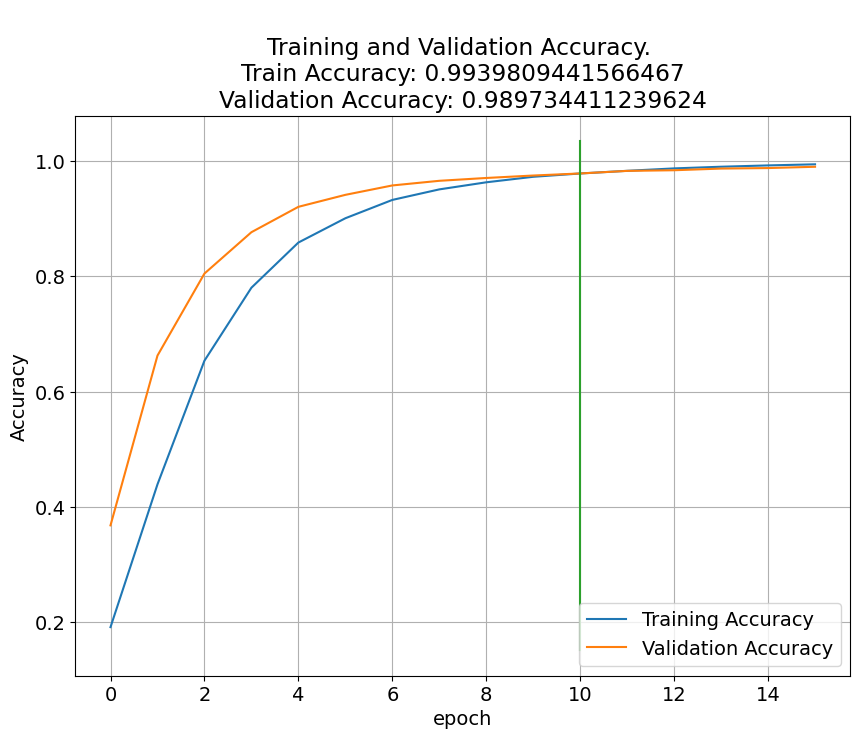

In [32]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')
plt.plot([10, 10],
          plt.ylim(), label='Start Fine Tuning')

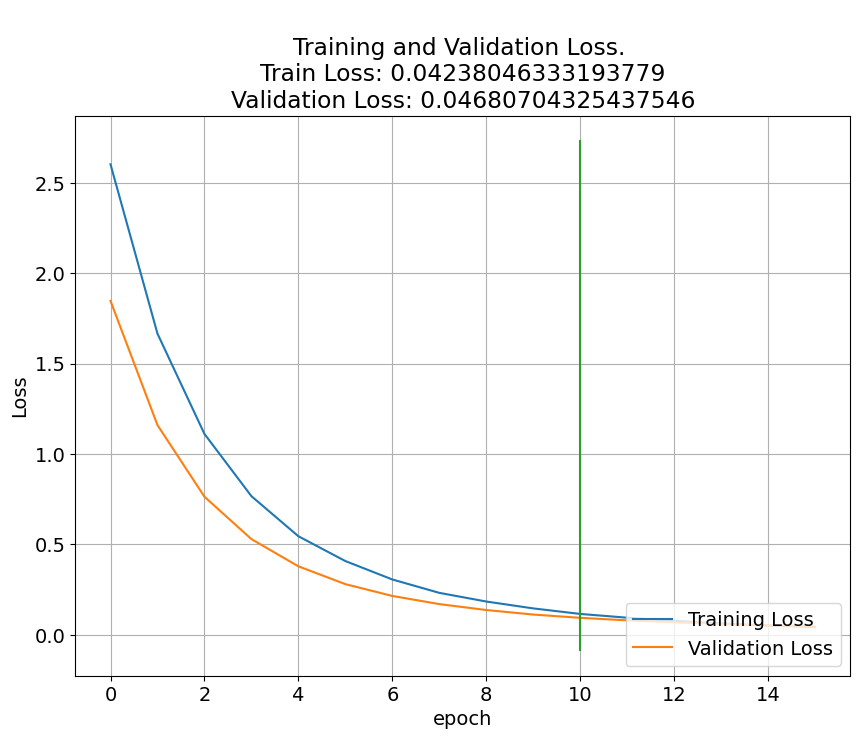

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title(f'\nTraining and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.plot([10, 10],
          plt.ylim(), label='Start Fine Tuning')

In [26]:
test_data = test_gen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = IMG_SIZE,
    classes = ['test'],
    batch_size = 32
)

Found 79726 images belonging to 1 classes.


In [28]:
preds = model.predict(test_data)

2492/2492 [==============================] - 709s 284ms/step


In [29]:
import os

base_dir = '/kaggle/working/'

test_imgs = os.path.join(base_dir, "imgs/test")

test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns = ['img','c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
for i in range(len(preds)):
    pred_df.loc[i, 'img'] = test_ids[i]
    pred_df.loc[i, 'c0':'c9'] = preds[i]
    
pred_df.to_csv('xception-predictions.csv', index=False)

**End Of Code**